<a href="https://www.kaggle.com/code/olgatasenko/classification-with-acoustic-features?scriptVersionId=171050831" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install opensmile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 9.6 MB/s eta 0:00:00
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168840 sha256=939d653fb41e0b7bf209575e7bb057c076b5b22edb6951cb1b8bdd91edfaa518
  Stored in directory: /root/.cache/pip/wheels/d8/78/cc/5478ca3b1c3f602eae6f8cdbd78f909c0a0bfa0bbcb5c7771f
Successfully built iso-639


In [2]:
import audiofile
import opensmile
from pathlib import Path

import pandas as pd 
import numpy as np
import joblib
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn import metrics
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import tree 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


import warnings
warnings.filterwarnings("ignore")

# Extract features

In [3]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
features_names = smile.feature_names

In [4]:
def get_features(file_path):
    signal, sampling_rate = audiofile.read(file_path, always_2d=True)
    result = smile.process_signal(signal, sampling_rate)
    return list(result.iloc[0])

In [5]:
p = Path("/kaggle/input/control-preprocessed")
control_features = []

for x in p.iterdir():
    result = get_features(str(x)) 
    control_features.append(result)

In [6]:
p = Path("/kaggle/input/patients-prepocessed")
patients_features = []

for x in p.iterdir():
    result = get_features(str(x)) 
    patients_features.append(result)

In [7]:
control_df = pd.DataFrame(control_features, columns = features_names, dtype = float)

patient_df = pd.DataFrame(patients_features, columns = features_names, dtype = float)

In [8]:
df_pat = patient_df[['F0semitoneFrom27.5Hz_sma3nz_amean','F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
    'loudness_sma3_amean','loudness_sma3_stddevNorm', 'spectralFlux_sma3_amean',
    'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 
    'mfcc2_sma3_stddevNorm','mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'jitterLocal_sma3nz_amean',
    'jitterLocal_sma3nz_stddevNorm', 'shimmerLocaldB_sma3nz_amean','shimmerLocaldB_sma3nz_stddevNorm',
    'F1frequency_sma3nz_amean','F1frequency_sma3nz_stddevNorm', 'F1bandwidth_sma3nz_amean',
    'F1bandwidth_sma3nz_stddevNorm', 'F2frequency_sma3nz_amean','F2frequency_sma3nz_stddevNorm', 
    'F2bandwidth_sma3nz_amean','F2bandwidth_sma3nz_stddevNorm', 'F3frequency_sma3nz_amean',
    'F3frequency_sma3nz_stddevNorm', 'F3bandwidth_sma3nz_amean','F3bandwidth_sma3nz_stddevNorm']]

df_con = control_df[['F0semitoneFrom27.5Hz_sma3nz_amean','F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
    'loudness_sma3_amean','loudness_sma3_stddevNorm', 'spectralFlux_sma3_amean',
    'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 
    'mfcc2_sma3_stddevNorm','mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'jitterLocal_sma3nz_amean',
    'jitterLocal_sma3nz_stddevNorm', 'shimmerLocaldB_sma3nz_amean','shimmerLocaldB_sma3nz_stddevNorm',
    'F1frequency_sma3nz_amean','F1frequency_sma3nz_stddevNorm', 'F1bandwidth_sma3nz_amean',
    'F1bandwidth_sma3nz_stddevNorm', 'F2frequency_sma3nz_amean','F2frequency_sma3nz_stddevNorm', 
    'F2bandwidth_sma3nz_amean','F2bandwidth_sma3nz_stddevNorm', 'F3frequency_sma3nz_amean',
    'F3frequency_sma3nz_stddevNorm', 'F3bandwidth_sma3nz_amean','F3bandwidth_sma3nz_stddevNorm']]

# PCA

In [9]:
def apply_pca(X, standardize=True):
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca)
    return X_pca

# Code

In [10]:
df_con['target'] = ['control'] * len(df_con)
df_pat['target'] = ['patient'] * len(df_pat)

df_merged = pd.concat([df_pat, df_con], axis=0, ignore_index=True)

In [11]:
df_merged

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,loudness_sma3_amean,loudness_sma3_stddevNorm,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,...,F1bandwidth_sma3nz_stddevNorm,F2frequency_sma3nz_amean,F2frequency_sma3nz_stddevNorm,F2bandwidth_sma3nz_amean,F2bandwidth_sma3nz_stddevNorm,F3frequency_sma3nz_amean,F3frequency_sma3nz_stddevNorm,F3bandwidth_sma3nz_amean,F3bandwidth_sma3nz_stddevNorm,target
0,34.514202,0.232929,0.819241,0.988821,0.878618,1.344338,18.861874,1.156416,13.127023,1.035955,...,0.247063,1714.491211,0.250017,952.383362,0.445429,2890.214111,0.106325,755.933044,0.612625,patient
1,33.393406,0.218617,0.509318,0.957057,0.440044,1.151958,24.628897,0.983111,15.651409,1.047899,...,0.241575,1758.718140,0.177935,841.546326,0.496683,2921.655029,0.106217,768.641846,0.589766,patient
2,36.355198,0.194799,0.604569,1.109563,0.451689,1.365438,18.679726,1.396050,11.929869,1.343641,...,0.266905,1760.150635,0.222017,997.392578,0.380050,2851.784912,0.136056,964.599548,0.442332,patient
3,33.150230,0.166384,0.753195,0.945784,0.714744,1.078660,22.373871,0.920746,18.499468,0.705123,...,0.207727,1740.653320,0.182719,969.874939,0.393330,2833.348633,0.104170,865.746765,0.410083,patient
4,39.982841,0.182613,0.497613,1.429944,0.384590,1.519118,13.499602,1.958761,7.642491,2.217459,...,0.261003,1837.542847,0.219162,802.580566,0.518044,2856.891357,0.142103,891.305908,0.406497,patient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,34.507988,0.267102,1.341372,0.835802,1.521541,1.085511,18.086668,1.140942,-8.206750,-2.163105,...,0.287099,1713.817505,0.198086,897.805359,0.447520,2755.479248,0.127315,896.542297,0.497670,control
306,33.963573,0.262463,0.935504,0.847212,1.041354,1.236536,23.390802,0.973114,9.750354,1.824072,...,0.275053,1729.928711,0.177718,988.103210,0.393767,2860.708740,0.112494,847.971802,0.515323,control
307,35.389187,0.168895,0.624486,0.841162,0.493213,1.036713,21.003769,1.007140,10.158144,1.660060,...,0.224781,1698.460571,0.179135,1045.604858,0.338855,2845.493896,0.123505,1012.590454,0.405057,control
308,33.495243,0.263251,0.881489,0.747840,1.046347,1.060802,22.229185,0.944373,18.065525,0.910619,...,0.258561,1913.132324,0.196657,812.539429,0.574689,2955.838379,0.095939,831.093628,0.500339,control


In [12]:
X = df_merged.drop(columns = ['target'])
y = df_merged['target']
X_pca = apply_pca(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.34, random_state=123, stratify=y)
print(f'train size={len(y_train)}, test size ={len(y_test)}')

train size=204, test size =106


In [14]:
def results(results):
    print(f'Optimal Hyperparams: {results.best_params_}')
    mean = results.cv_results_['mean_test_score']

    for mean, params in zip(mean, results.cv_results_['params']):
        print(f'Recall {round(mean, 3)}, Hyperparameters {params}')

# LogisticRegression

In [15]:
np.random.seed(123)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"LogisticRegression\n{classification_report(y_test, y_pred, target_names=['patient', 'control'])}")

LogisticRegression
              precision    recall  f1-score   support

     patient       0.89      0.91      0.90        53
     control       0.90      0.89      0.90        53

    accuracy                           0.90       106
   macro avg       0.90      0.90      0.90       106
weighted avg       0.90      0.90      0.90       106



# RandomForestClassifier

In [16]:
np.random.seed(123)
rf0 = RandomForestClassifier()
rf0.fit(X_train, y_train)
y_pred = rf0.predict(X_test)
print(f"DecisionTreeClassifier\n{classification_report(y_test, y_pred, target_names=['patient', 'control'])}")

DecisionTreeClassifier
              precision    recall  f1-score   support

     patient       0.92      0.91      0.91        53
     control       0.91      0.92      0.92        53

    accuracy                           0.92       106
   macro avg       0.92      0.92      0.92       106
weighted avg       0.92      0.92      0.92       106



In [17]:
np.random.seed(123)
rf = RandomForestClassifier()
hyperparams = {
    'n_estimators': [50,100, 200, 300],
    'max_depth': [24, 48, 96, None]
}

cross_val = GridSearchCV(rf, hyperparams, cv=5)
cross_val.fit(X_train, y_train)
results(cross_val)

Optimal Hyperparams: {'max_depth': 96, 'n_estimators': 100}
Recall 0.838, Hyperparameters {'max_depth': 24, 'n_estimators': 50}
Recall 0.794, Hyperparameters {'max_depth': 24, 'n_estimators': 100}
Recall 0.853, Hyperparameters {'max_depth': 24, 'n_estimators': 200}
Recall 0.853, Hyperparameters {'max_depth': 24, 'n_estimators': 300}
Recall 0.799, Hyperparameters {'max_depth': 48, 'n_estimators': 50}
Recall 0.843, Hyperparameters {'max_depth': 48, 'n_estimators': 100}
Recall 0.877, Hyperparameters {'max_depth': 48, 'n_estimators': 200}
Recall 0.843, Hyperparameters {'max_depth': 48, 'n_estimators': 300}
Recall 0.843, Hyperparameters {'max_depth': 96, 'n_estimators': 50}
Recall 0.882, Hyperparameters {'max_depth': 96, 'n_estimators': 100}
Recall 0.862, Hyperparameters {'max_depth': 96, 'n_estimators': 200}
Recall 0.843, Hyperparameters {'max_depth': 96, 'n_estimators': 300}
Recall 0.872, Hyperparameters {'max_depth': None, 'n_estimators': 50}
Recall 0.858, Hyperparameters {'max_depth': N

In [18]:
np.random.seed(123)
rf1 = RandomForestClassifier(n_estimators=300, max_depth=96)
rf2 = RandomForestClassifier(n_estimators=200, max_depth=None)
rf3 = RandomForestClassifier(n_estimators=300, max_depth=None)

clf = [rf1, rf2, rf3]
lab = ['rf1', 'rf2', 'rf3']

for clf, lab in zip(clf, lab):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['patient', 'control'])
    print(clf, '\n', report)
    joblib.dump(clf, lab)

RandomForestClassifier(max_depth=96, n_estimators=300) 
               precision    recall  f1-score   support

     patient       0.93      0.94      0.93        53
     control       0.94      0.92      0.93        53

    accuracy                           0.93       106
   macro avg       0.93      0.93      0.93       106
weighted avg       0.93      0.93      0.93       106

RandomForestClassifier(n_estimators=200) 
               precision    recall  f1-score   support

     patient       0.93      0.94      0.93        53
     control       0.94      0.92      0.93        53

    accuracy                           0.93       106
   macro avg       0.93      0.93      0.93       106
weighted avg       0.93      0.93      0.93       106

RandomForestClassifier(n_estimators=300) 
               precision    recall  f1-score   support

     patient       0.96      0.94      0.95        53
     control       0.94      0.96      0.95        53

    accuracy                           

# SVM

In [19]:
np.random.seed(123)
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
#print(clf.decision_function(X_train))
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['patient', 'control'])
print(report)
joblib.dump(clf, 'SVM.pkl')

              precision    recall  f1-score   support

     patient       0.98      0.96      0.97        53
     control       0.96      0.98      0.97        53

    accuracy                           0.97       106
   macro avg       0.97      0.97      0.97       106
weighted avg       0.97      0.97      0.97       106



['SVM.pkl']

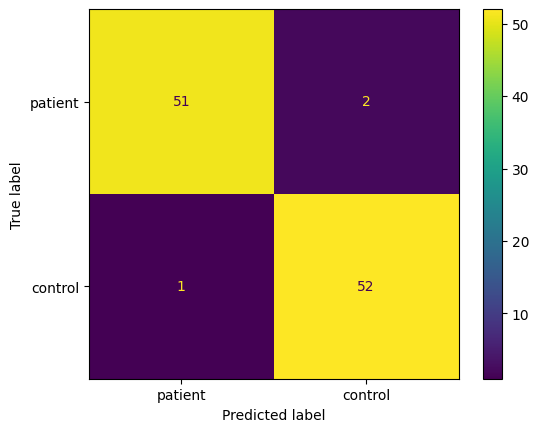

In [20]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['patient', 'control'])

cm_display.plot()
plt.show()

In [21]:
print(f'accuracy = {accuracy_score(y_test, y_pred)}')
print('precision = ', precision_score(y_test, y_pred, average='macro'))
print('recall = ', recall_score(y_test, y_pred, average='macro'))
print('f1 = ', f1_score(y_test, y_pred, average='macro'))

accuracy = 0.9716981132075472
precision =  0.9718660968660968
recall =  0.9716981132075472
f1 =  0.9716955941255006


# Some visializathion

In [22]:
model = []

for i, j in zip(list(y_test), list(y_pred)):
    if i == j:
         model.append("верное предсказание")
    else:
         model.append("ошибка")
        
shiz = []
for i in list(y_test):
    if i == 'patient':
        shiz.append('есть шизофрения')
    else:
        shiz.append('нет шизофрения')

In [23]:
df = pd.DataFrame()
df['предсказание модели'] = model
df['шизофрения'] = shiz

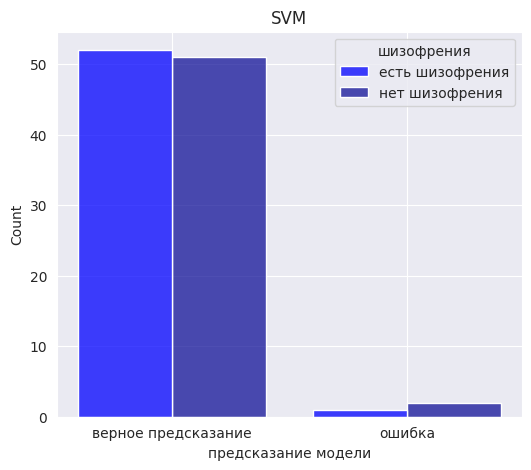

In [24]:
sns.set_style("darkgrid")

plt.figure(figsize=(6,5))
sns.set_palette(sns.dark_palette(color='blue', n_colors=3, reverse=True))
fig = sns.histplot(data=df, x="предсказание модели", hue="шизофрения", multiple="dodge", shrink=.8)
plt.title('SVM')
plt.show()

Text(0.5, 0, 'Permutation Importance')

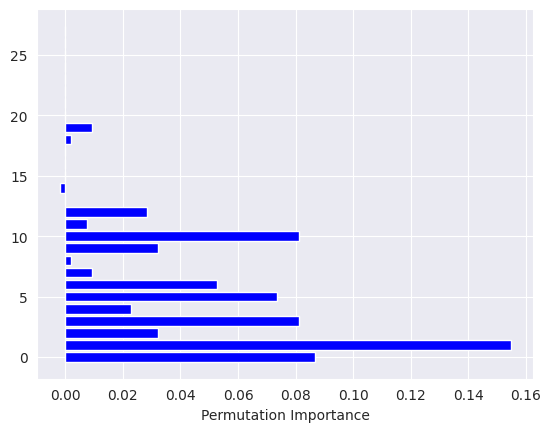

In [25]:
svc = joblib.load('/kaggle/working/SVM.pkl')

perm_importance = permutation_importance(svc, X_test, y_test)

feature_names = list(X_train.columns)
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")